# Modeling of duration esitmation under memory load (add predict_newdata_from_posterior in model)

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_s \log(M)$$

changed equation in the previous model from $$\sigma_{wm}^2 = \sigma_s^2 (1+ l_s\cdot \log(M+T_g))$$ to 

$$\sigma_{wm}^2 = \sigma_s^2 (1 +  l_s \cdot \log(M) + t_s \cdot \log(T))$$ by adding new parameter $$t_s$$
\cdot 
where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [231]:
#!pip install numpy
#!pip install pymc
#!pip install arviz
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install datetime
#!pip install pytensor


import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os
import pytensor.tensor as pt


In [232]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2025-11-19 21:27:46.092841


In [233]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllExpData_color_new.csv')

# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()

freeParam = False
constrain = [0,0,0,0]
modelname = 'FreeParameters'
if freeParam:
    modelname = 'FreeParameters'
else:
    modelname = 'Experimentwise'
    
modelpath = modelname +'/'

In [236]:
# get the parent directory
cpath = os.path.dirname(os.getcwd()) # 项目根路径或你保存数据的根路径
OUTPUT_PATH = os.path.join(cpath, 'data', modelpath)
savefigpath = cpath + '/data/'+ modelpath
OUTPUT_PATH

'/Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/'

In [237]:
expData.Gap.unique()

array([2.95, 2.45, 3.1 , 2.  , 0.5 , 2.5 ])

In [238]:
# find out the unique gap from ExpName Both_gap
expData[expData['ExpName'] == 'Both_gap']['gap'].unique()

array([2, 1])

In [239]:
subid_new = np.repeat(np.arange(16), len(xnew))
subid_new

array([ 0,  0,  0, ..., 15, 15, 15])

In [240]:
# =========================================================
# 1. 新输入：xnew, Gapnew, WMSize_new  （846 rows）
# =========================================================
xnew = np.tile(np.linspace(0.4, 1.8, 141), 6)

Gapnew = np.concatenate([
    np.repeat(0.5, 141*3),
    np.repeat(2.5, 141*3)
])

WMnew = np.concatenate([
    np.repeat(1, 141),
    np.repeat(3, 141),
    np.repeat(5, 141),
    np.repeat(1, 141),
    np.repeat(3, 141),
    np.repeat(5, 141)
])

df_rlt = pd.DataFrame({
    "curDur": xnew,
    "Gap": Gapnew,
    "WMSize": WMnew
})




In [241]:
# define PYMC partial pooling model
trace = 0

def hModel(dat, constrain):
    subid = (dat.NSub - 1).astype(int)
    nsub = len(dat.NSub.unique())

    # log-transformed predictors
    wm_idx = np.log(dat.WMSize.to_numpy())
    gap_idx = np.log(dat.Gap.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnDur = np.log(durs)
    
    #n_new = df_rlt.shape[0]  # 846
    #df_new = pd.concat([df_rlt] * nsub, ignore_index=True)
    ## 加上 subject index
    #df_new["NSub"] = np.repeat(np.arange(1, nsub + 1), n_new)

    #lnDur_new  = np.log(df_new["curDur"].to_numpy())      
    #wm_idx_new = np.log(df_new["WMSize"].to_numpy())      
    #gap_idx_new = np.log(df_new["Gap"].to_numpy())        
    #subid_new = df_new["NSub"].to_numpy().astype(int)  


    niter = 2000

    with pm.Model() as WMmodel:
        # -----------------------------
        # Hierarchical Priors
        # -----------------------------
        # var_s: sensory noise
        mu_var_s = pm.HalfCauchy('mu_var_s', beta=1)
        sd_var_s = pm.HalfCauchy('sd_var_s', beta=1)
        var_s_raw = pm.Normal('var_s_raw', 0, 1, shape=nsub)
        var_s = pm.Deterministic('var_s', pm.math.abs(mu_var_s + sd_var_s * var_s_raw))

        # mu_p: prior mean (log-space)
        mu_mu_p = pm.Normal('mu_mu_p', mu=0, sigma=1)
        sd_mu_p = pm.HalfCauchy('sd_mu_p', beta=1)
        mu_p_raw = pm.Normal('mu_p_raw', 0, 1, shape=nsub)
        mu_p = pm.Deterministic('mu_p', pm.math.clip(mu_mu_p + sd_mu_p * mu_p_raw, -1, 1.3))

        # var_p: prior variance (log-space)
        mu_var_p = pm.HalfNormal('mu_var_p', sigma=1)
        sd_var_p = pm.HalfNormal('sd_var_p', sigma=1)
        var_p_raw = pm.Normal('var_p_raw', 0, 1, shape=nsub)
        var_p = pm.Deterministic('var_p', pm.math.clip(mu_var_p + sd_var_p * var_p_raw, 0, 1))

        # var_n: motor noise
        mu_var_n = pm.HalfCauchy('mu_var_n', beta=1)
        sd_var_n = pm.HalfCauchy('sd_var_n', beta=1)
        var_n_raw = pm.Normal('var_n_raw', 0, 1, shape=nsub)
        var_n = pm.Deterministic('var_n', pm.math.abs(mu_var_n + sd_var_n * var_n_raw))

        # -----------------------------
        # Other parameters (kept subject-specific)
        # -----------------------------
        k_s = pm.Uniform('k_s', lower=0, upper=0.1, shape=nsub) if constrain[0] else pm.Deterministic('k_s', pt.zeros(nsub))
        l_s = pm.Uniform('l_s', lower=0, upper=0.1, shape=nsub) if constrain[1] else pm.Deterministic('l_s', pt.zeros(nsub))
        k_r = pm.Uniform('k_r', lower=0, upper=0.1, shape=nsub) if constrain[2] else pm.Deterministic('k_r', pt.zeros(nsub))
        t_s = pm.Uniform('t_s', lower=0, upper=0.1, shape=nsub) if constrain[3] else pm.Deterministic('t_s', pt.zeros(nsub))
        
        # -----------------------------
        # Model equations
        # -----------------------------
        D_s = lnDur - k_s[subid] * wm_idx
        var_wm = var_s[subid] * (1 + l_s[subid] * wm_idx + t_s[subid] * gap_idx)
        w_p = var_wm / (var_p[subid] + var_wm)
        u_x = (1 - w_p) * D_s + w_p * mu_p[subid]
        var_x = var_wm * var_p[subid] / (var_wm + var_p[subid])
        u_x1 = u_x + k_r[subid] * wm_idx
        u_r = pm.math.exp(u_x1 + var_x / 2)
        sig_r = pm.math.sqrt((pm.math.exp(var_x) - 1) * pm.math.exp(2 * u_x1 + var_x) + var_n[subid] / durs)

        # -----------------------------
        # Likelihood
        # -----------------------------
        resp_like = pm.Normal('resp_like', mu=u_r, sigma=sig_r, observed=repDur)


        # -----------------------------
        # Sampling
        # -----------------------------
        idata = pm.sample(draws=niter, tune=1000, target_accept=0.9, return_inferencedata=True)

        # Add log_likelihood if missing
        try:
            log_like = pm.compute_log_likelihood(idata, model=WMmodel)
            if "log_likelihood" not in idata.groups():
                idata.add_groups({"log_likelihood": log_like})
        except Exception as e:
            print(f"Could not recompute log_likelihood: {e}")

    return idata, WMmodel


In [242]:
# ====== Prediction (post-sampling) ======
def predict_newdata_from_posterior(idata, df_new, nsub):
    """
    Compute predictions for new data (df_new repeated for each subject).
    - idata: InferenceData returned from hModel
    - df_new: DataFrame with columns ['curDur','Gap','WMSize'] for ONE SUBJECT set (846 rows)
             (we will tile it across subjects outside or inside this function)
    - nsub: number of subjects (e.g., 16)
    Returns: df_pred (Nsub * 846 rows) with columns:
             ['NSub','xnew','WMSize','Gap','draw_mean','draw_sd','ci2.5','ci97.5']
    """

    # 1) build the big dataframe (each subject has the same 846 rows)
    n_new = df_new.shape[0]  # 846
    df_big = pd.concat([df_new]*nsub, ignore_index=True)
    df_big['NSub'] = np.repeat(np.arange(1, nsub+1), n_new)

    # numpy arrays for the big df (length = nsub*n_new)
    curDur_arr = df_big['curDur'].to_numpy()
    Gap_arr = df_big['Gap'].to_numpy()
    WM_arr = df_big['WMSize'].to_numpy()
    subid_new = (df_big['NSub'] - 1).to_numpy().astype(int)  # 0-based

    lnDur_new = np.log(curDur_arr)
    wm_idx_new = np.log(WM_arr)
    gap_idx_new = np.log(Gap_arr)
    durs_new = curDur_arr

    # 2) extract posterior samples and stack chains/draws -> (ndraws, nsub)
    post = idata.posterior
    # function to stack chain/draw dims
    def stack_param(name):
        arr = post[name].values  # shape (chain, draw, nsub) for subject-specific
        arr = arr.reshape(-1, arr.shape[-1])  # (ndraws, nsub)
        return arr

    # subject-specific parameters: shape -> (ndraws, nsub)
    var_s_samps = stack_param('var_s')    # (ndraws, nsub)
    mu_p_samps  = stack_param('mu_p')
    var_p_samps = stack_param('var_p')
    var_n_samps = stack_param('var_n')
    k_s_samps   = stack_param('k_s')
    l_s_samps   = stack_param('l_s')
    k_r_samps   = stack_param('k_r')
    t_s_samps   = stack_param('t_s')

    ndraws = var_s_samps.shape[0]

    # 3) We will compute predictions for each draw, for all (subject,newpoint)
    #    Result shape: (ndraws, nsub * n_new)
    preds = np.zeros((ndraws, nsub * n_new), dtype=float)

    # To speed up: vectorized per-draw loop
    # For each draw i we have arrays of subject params shape (nsub,)
    for i in range(ndraws):
        # vectors length nsub
        var_s_i = var_s_samps[i]   # (nsub,)
        mu_p_i  = mu_p_samps[i]
        var_p_i = var_p_samps[i]
        var_n_i = var_n_samps[i]
        k_s_i   = k_s_samps[i]
        l_s_i   = l_s_samps[i]
        k_r_i   = k_r_samps[i]
        t_s_i   = t_s_samps[i]

        # map subject vectors to the big new-data index: broadcast to length nsub*n_new
        var_s_map = var_s_i[subid_new]    # (nsub*n_new,)
        mu_p_map  = mu_p_i[subid_new]
        var_p_map = var_p_i[subid_new]
        var_n_map = var_n_i[subid_new]
        k_s_map   = k_s_i[subid_new]
        l_s_map   = l_s_i[subid_new]
        k_r_map   = k_r_i[subid_new]
        t_s_map   = t_s_i[subid_new]

        # compute forward model (same algebra as in model)
        D_s_new = lnDur_new - k_s_map * wm_idx_new
        var_wm_new = var_s_map * (1.0 + l_s_map * wm_idx_new + t_s_map * gap_idx_new)
        w_p_new = var_wm_new / (var_p_map + var_wm_new)
        u_x_new = (1.0 - w_p_new) * D_s_new + w_p_new * mu_p_map
        var_x_new = var_wm_new * var_p_map / (var_wm_new + var_p_map)
        u_x1_new = u_x_new + k_r_map * wm_idx_new
        u_r_new = np.exp(u_x1_new + var_x_new / 2.0)

        # if your likelihood had motor noise term dividing by duration, include it exactly:
        sig_r_new = np.sqrt((np.exp(var_x_new) - 1.0) * np.exp(2.0 * u_x1_new + var_x_new) + var_n_map / durs_new)

        # Draw a predictive sample from Normal(mu=u_r_new, sigma=sig_r_new)
        # We want the posterior predictive distribution for y_new: sample once per draw
        preds[i, :] = np.random.normal(loc=u_r_new, scale=sig_r_new)

    # 4) summarize draws -> mean, sd, 95% CI per (subject,newpoint)
    mean_pred = preds.mean(axis=0)
    sd_pred = preds.std(axis=0)
    ci_low = np.percentile(preds, 2.5, axis=0)
    ci_high = np.percentile(preds, 97.5, axis=0)
    
    pred_mean = preds.mean(axis=0).reshape(-1)
    pred_lower = np.percentile(preds, 2.5, axis=0).reshape(-1)
    pred_upper = np.percentile(preds, 97.5, axis=0).reshape(-1)


    # Build df with results
    out_df = pd.DataFrame({
        'NSub': df_big['NSub'].values,
        'xnew': df_big['curDur'].values,
        'WMSize': df_big['WMSize'].values,
        'Gap': df_big['Gap'].values,
        'mPred': mean_pred,
        'sdPred': sd_pred,
        'CI_low': ci_low,
        'CI_high': ci_high,
        'pred_lower': pred_lower,
        'pred_upper': pred_upper
    })

    return out_df, preds  # out_df: (nsub*n_new rows), preds: (ndraws, nsub*n_new)


In [243]:
# ====== Group-level summary & plot helpers ======
def get_group_summary(df_new):
    # group by xnew and WMSize, average across subjects' point estimates (mPred) and CIs
    grp = df_new.groupby(['xnew', 'WMSize']).agg(
        mPred=('mPred', 'mean'),
        CI_low=('CI_low', 'mean'),
        CI_high=('CI_high', 'mean')
    ).reset_index()
    return grp


In [244]:

# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'Gap', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	nGap = len(dat.Gap.unique())
	for i in range(nsub):  #i = 0,1,..., 15
		for j in range(nDur):
			for k in range(nWM):
				for g in range(nGap):
					subid = i + 1 # subid = 1,2,..., 16
					curDur = dat.curDur.unique()[j]
					WMSize = dat.WMSize.unique()[k]
					gap = dat.Gap.unique()[g]
					idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize) & (dat.Gap == gap)
					if np.sum(idx) > 0:
						#log scale to linear scale
						mPred = np.mean(posterior_samples[:, idx])
						sdPred = np.std(posterior_samples[:, idx])
						df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'Gap': gap, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
						# concatenate the dataframe
						posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize','Gap']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize','Gap'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# Define a customized color palette for the plot
customized_palette = sns.color_palette(['#d9d9d9', '#838383', '#3b3b3b'])

In [245]:
def runModel(dat, constrain, model_name):
    
    trace = az.from_netcdf(cpath + '/data/' + model_name + '_trace.nc')
    para = az.summary(trace)

    xnew = np.tile(np.linspace(0.4, 1.8, 141), 6)   # 141 * 6 = 846
    Gapnew = np.concatenate([
        np.repeat(0.5, 141*3),
        np.repeat(2.5, 141*3)
    ])
    WMnew = np.concatenate([
        np.repeat(1, 141),
        np.repeat(3, 141),
        np.repeat(5, 141),
        np.repeat(1, 141),
        np.repeat(3, 141),
        np.repeat(5, 141)
    ])
    df_new_single = pd.DataFrame({'curDur': xnew, 'Gap': Gapnew, 'WMSize': WMnew})

    # 4) compute predictions for all subjects
    nsub = len(dat.NSub.unique())
    df_new_all, preds = predict_newdata_from_posterior(trace, df_new_single, nsub=nsub)

    np.save(os.path.join(cpath, 'data', f'{model_name}_preds.npy'), preds)
    # 5) group-level summary
    df_group = get_group_summary(df_new_all)
    
    df_new_all.to_csv(os.path.join(cpath, 'data', f'{model_name}_newPred.csv'), index=False)
    df_group.to_csv(os.path.join(cpath, 'data', f'{model_name}_newPred_group.csv'), index=False)

    # === LOO diagnostics ===
    try:
        loo = az.loo(trace, model=model)
        az.plot_khat(loo)
        plt.tight_layout()
        plt.savefig(savefigpath + model_name + '_khat.png', dpi=300)
        plt.show()
        print(az.summary(loo, var_names=["pareto_k"]))
    except Exception as e:
        print(f"LOO computation failed: {e}")

    return trace, para, df_new_all, df_group

In [246]:
def runModel_old(dat, constrain, model_name):
    trace, model = hModel(dat, constrain)
    # Save outputs
    az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')

    with model:
        ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
    posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy()
    posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2])
    
    
    mdat = getPosteriorSummary(posterior_samples, dat)
    para = az.summary(trace)

    # Save outputs
    mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
    para.to_csv(cpath + '/data/' + model_name + '_para.csv')
    

    xnew = np.tile(np.linspace(0.4, 1.8, 141), 6)   # 141 * 6 = 846
    Gapnew = np.concatenate([
        np.repeat(0.5, 141*3),
        np.repeat(2.5, 141*3)
    ])
    WMnew = np.concatenate([
        np.repeat(1, 141),
        np.repeat(3, 141),
        np.repeat(5, 141),
        np.repeat(1, 141),
        np.repeat(3, 141),
        np.repeat(5, 141)
    ])
    df_new_single = pd.DataFrame({'curDur': xnew, 'Gap': Gapnew, 'WMSize': WMnew})

    # 4) compute predictions for all subjects
    nsub = len(dat.NSub.unique())
    df_new_all, preds = predict_newdata_from_posterior(trace, df_new_single, nsub=nsub)

    np.save(os.path.join(cpath, 'data', f'{model_name}_preds.npy'), preds)
    # 5) group-level summary
    df_group = get_group_summary(df_new_all)
    
    df_new_all.to_csv(os.path.join(cpath, 'data', f'{model_name}_newPred.csv'), index=False)
    df_group.to_csv(os.path.join(cpath, 'data', f'{model_name}_newPred_group.csv'), index=False)

    # === LOO diagnostics ===
    try:
        loo = az.loo(trace, model=model)
        az.plot_khat(loo)
        plt.tight_layout()
        plt.savefig(savefigpath + model_name + '_khat.png', dpi=300)
        plt.show()
        print(az.summary(loo, var_names=["pareto_k"]))
    except Exception as e:
        print(f"LOO computation failed: {e}")

    return trace, model, para, mdat, df_new_all, df_group, preds

In [247]:
def getGroupLevelPrediction(df_new):
    df_group = df_new.groupby(["xnew", "WMSize"]).agg(
        mPred=("mPred", "mean"),
        CI_low=("CI_low", "mean"),
        CI_high=("CI_high", "mean")
    ).reset_index()

    return df_group

In [248]:
def plotModelPred(mdat, figname='model_pred.png'):

    from matplotlib.lines import Line2D

    # Ensure category
    mdat['WMSize'] = mdat['WMSize'].astype('category')
    mdat['Gap'] = mdat['Gap'].astype(float)

    # Gap → style
    gap_levels = sorted(mdat['Gap'].unique())
    ls_map = {0.5: '-', 2.5: '--'}

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    sns.set_theme(style="white", context="paper")

    # ----------------------------------------------------------------------
    # 1. Bias panel (repErr + predErr), but now grouped by Gap as well
    # ----------------------------------------------------------------------
    for g in gap_levels:

        sub = mdat[mdat['Gap'] == g]

        # repErr (points)
        sns.pointplot(
            data=sub, x='curDur', y='repErr', hue='WMSize',
            palette=customized_palette, ax=ax[0],
            linestyles='', markers='o', errorbar='se',
            dodge=0.25, legend=False
        )

        # predErr (lines by Gap)
        sns.pointplot(
            data=sub, x='curDur', y='predErr', hue='WMSize',
            palette=customized_palette, ax=ax[0],
            markers='', linestyles=ls_map[g], errorbar=None,
            dodge=0.25, legend=False
        )

    ax[0].text(0.05, 0.05, figname.capitalize(), transform=ax[0].transAxes)
    ax[0].set_title("Bias")
    ax[0].set_xlabel("Duration (s)")
    ax[0].set_ylabel("Rep. Bias (s)")

    # ----------------------------------------------------------------------
    # 2. CV panel (repCV + predCV)
    # ----------------------------------------------------------------------
    for g in gap_levels:

        sub = mdat[mdat['Gap'] == g]

        # repCV
        sns.pointplot(
            data=sub, x='curDur', y='repCV', hue='WMSize',
            palette=customized_palette, ax=ax[1],
            linestyles='', markers='o', errorbar='se',
            dodge=0.25, legend=False
        )

        # predCV
        sns.pointplot(
            data=sub, x='curDur', y='predCV', hue='WMSize',
            palette=customized_palette, ax=ax[1],
            markers='', linestyles=ls_map[g], errorbar=None,
            dodge=0.25, legend=False
        )

    ax[1].set_title("CV")
    ax[1].set_xlabel("Duration (s)")
    ax[1].set_ylabel("Mean CV")

    # ----------------------------------------------------------------------
    # 3. Scatter panel (Observed vs Predicted), grouped by Gap
    # ----------------------------------------------------------------------
    for g in gap_levels:
        sub = mdat[mdat['Gap'] == g]
        sns.scatterplot(
            data=sub, x='repErr', y='predErr', hue='WMSize',
            style='Gap', palette=customized_palette,
            markers=True, ax=ax[2], legend=False
        )

    ax[2].set_title("Observed vs Predicted Bias")
    ax[2].set_xlabel("Observed Bias (s)")
    ax[2].set_ylabel("Predicted Bias (s)")

    # ---------------- Legend (WMSize always shown; Gap only if >1 level) ----------------
    handles_color, labels_color = ax[0].get_legend_handles_labels()

    # Gap 0.5 → short , 2.5 → long
    gap_name_map = {0.5: "short", 2.5: "long"}

    if len(gap_levels) > 1:
        # show gap legend only when 2 gaps exist
        gap_handles = [
            Line2D([0], [0], color='black', linestyle=ls_map[g],
                   label=gap_name_map.get(g, f"Gap {g}"))
            for g in gap_levels
        ]

        fig.legend(
            handles_color + gap_handles,
            labels_color + [gap_name_map.get(g, f"Gap {g}") for g in gap_levels],
            ncol=4, loc='lower center', frameon=False,
            bbox_to_anchor=(0.5, -0.05)
        )

    else:
        # only WMSize legend
        fig.legend(
            handles_color,
            labels_color,
            ncol=4, loc='lower center', frameon=False,
            bbox_to_anchor=(0.5, -0.05)
        )


    # Layout & save
    plt.tight_layout()
    plt.savefig(savefigpath + figname + "_model_pred.png", dpi=600, bbox_inches='tight')
    plt.show()

In [249]:
def plot_new_predictions(df):
    subs = df.NSub.unique()
    for s in subs:
        d = df[df.NSub == s]

        plt.figure(figsize=(8,5))
        for wm in [1,3,5]:
            dd = d[d.WMSize == wm]
            plt.plot(dd.xnew, dd.mPred, label=f"WM {wm}")
            plt.fill_between(dd.xnew, 
                             dd.mPred - dd.sdPred,
                             dd.mPred + dd.sdPred,
                             alpha=0.2)

        plt.title(f"Subject {s} - New Data Prediction")
        plt.xlabel("Duration (xnew)")
        plt.ylabel("Predicted Reproduction")
        plt.legend()
        plt.tight_layout()
        plt.show()


## Experiments with Memory Load on Encoding


Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

In [250]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
firstrun = False
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling parameters, ks, ls, ts, wm_sig, and kr
    else:
        constrain = [1,1,0,0]  # constrained, use only  ks, ls
    #encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, modelpath+'encoding')
    #encoding_trace, encoding_model, encoding_para, encoding_mdat, df_new_all, df_group, preds = runModel(dat_encoding, constrain, modelpath+'encoding')
    encoding_trace, encoding_para, encoding_new, encoding_group = runModel(dat_encoding, constrain, modelpath+'encoding')
else:
    encoding_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'encoding_trace.nc')
    encoding_mdat = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_mdat.csv')
    encoding_para = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_para.csv')

In [251]:
encoding_new['Exp'] = 'Encoding'
encoding_new.to_csv(cpath + '/data/'+ modelpath + 'encoding_new_all.csv')

In [252]:
encoding_group['Exp'] = 'Encoding'
encoding_group.to_csv(cpath + '/data/'+ modelpath + 'encoding_group.csv')

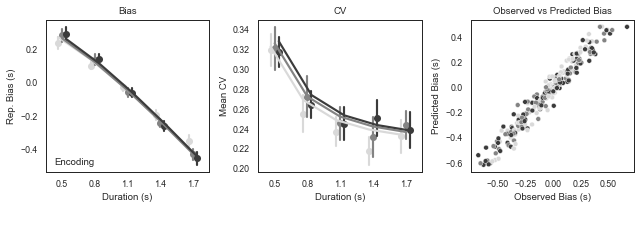

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.040,0.026,0.000,0.087,0.0,0.0,5344.0,2393.0,1.0
k_s[1],0.031,0.022,0.000,0.069,0.0,0.0,3721.0,1996.0,1.0
k_s[2],0.063,0.026,0.015,0.100,0.0,0.0,5055.0,1838.0,1.0
k_s[3],0.045,0.027,0.001,0.090,0.0,0.0,5960.0,2413.0,1.0
k_s[4],0.027,0.023,0.000,0.072,0.0,0.0,5742.0,2183.0,1.0
...,...,...,...,...,...,...,...,...,...
var_n[11],0.050,0.013,0.028,0.076,0.0,0.0,3727.0,2677.0,1.0
var_n[12],0.016,0.006,0.005,0.027,0.0,0.0,3204.0,3198.0,1.0
var_n[13],0.003,0.002,0.000,0.007,0.0,0.0,2919.0,2976.0,1.0
var_n[14],0.007,0.002,0.003,0.012,0.0,0.0,3714.0,3455.0,1.0


In [253]:
encoding_mdat['Exp'] = 'Encoding'
encoding_mdat['Gap'] = 0.5
plotModelPred(encoding_mdat, 'encoding')
az.summary(encoding_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [254]:
# calculate the correlation between mPred vs. repDur_mean using encoding_mdat
np.corrcoef(encoding_mdat['mPred'], encoding_mdat['repDur_mean'])

array([[1.        , 0.96244585],
       [0.96244585, 1.        ]])

In [255]:
np.corrcoef(encoding_mdat['repCV'], encoding_mdat['predCV'])

array([[1.        , 0.82753478],
       [0.82753478, 1.        ]])

## Memory Load on Reproduction


In [256]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']
firstrun = False
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling factors ks, kr, ls, ts
    else:
        constrain = [0,0,1,0] # constrained, only use scaling factors ks, ts
    #reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat, reproduction_new, reproduction_group, reproduction_preds = runModel(dat_reproduction, constrain, modelpath+'reproduction')
    reproduction_trace, reproduction_para, reproduction_new, reproduction_group = runModel(dat_reproduction, constrain, modelpath+'reproduction') 
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_para.csv')

In [257]:
reproduction_new['Exp'] = 'Reproduction'
reproduction_new.to_csv(cpath + '/data/'+ modelpath + 'reproduction_new_all.csv')

In [258]:
reproduction_group['Exp'] = 'Reproduction'
reproduction_group.to_csv(cpath + '/data/'+ modelpath + 'encoding_group.csv')

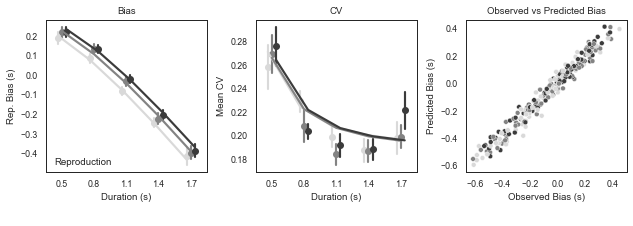

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.002,0.002,0.000,0.006,0.0,0.0,1920.0,2514.0,1.0
var_n[12],0.002,0.002,0.000,0.005,0.0,0.0,3353.0,2570.0,1.0
var_n[13],0.003,0.002,0.000,0.007,0.0,0.0,3335.0,3315.0,1.0
var_n[14],0.005,0.002,0.001,0.008,0.0,0.0,4548.0,3738.0,1.0


In [259]:
# plot the model prediction
reproduction_mdat['Exp'] = 'Reproduction'
reproduction_mdat['Gap'] = 0.5
plotModelPred(reproduction_mdat, 'reproduction')
az.summary(reproduction_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [260]:
np.corrcoef(reproduction_mdat['mPred'], reproduction_mdat['repDur_mean'])

array([[1.        , 0.98275522],
       [0.98275522, 1.        ]])

In [261]:
#correlation of CV
np.corrcoef(reproduction_mdat['repCV'], reproduction_mdat['predCV'])

array([[1.        , 0.69281043],
       [0.69281043, 1.        ]])

In [262]:
reproduction_mdat

,Unnamed: 0,NSub,curDur,WMSize,repDur_mean,repDur_std,mPred,sdPred,repErr,predErr,repCV,predCV,Exp,Gap
0,0,1,0.5,1,0.771986,0.281484,0.749325,0.247171,0.271986,0.249325,0.364622,0.329858,Reproduction,0.5
1,1,1,0.5,3,0.717311,0.298764,0.760022,0.247634,0.217311,0.260022,0.416505,0.325825,Reproduction,0.5
2,2,1,0.5,5,0.777309,0.262939,0.765547,0.248420,0.277309,0.265547,0.338268,0.324499,Reproduction,0.5
3,3,1,0.8,1,0.933316,0.218705,0.892264,0.227772,0.133316,0.092264,0.234331,0.255274,Reproduction,0.5
4,4,1,0.8,3,0.914644,0.225974,0.906216,0.229307,0.114644,0.106216,0.247063,0.253038,Reproduction,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,16,1.4,3,1.096584,0.303610,1.090154,0.217230,-0.303416,-0.309846,0.276869,0.199265,Reproduction,0.5
236,236,16,1.4,5,1.168591,0.211863,1.114891,0.222869,-0.231409,-0.285109,0.181298,0.199903,Reproduction,0.5
237,237,16,1.7,1,1.155933,0.133814,1.155009,0.226777,-0.544067,-0.544991,0.115763,0.196342,Reproduction,0.5
238,238,16,1.7,3,1.143946,0.160930,1.213741,0.237064,-0.556054,-0.486259,0.140679,0.195317,Reproduction,0.5


## Baseline Model

In [263]:
dat_baseline = expData[expData['ExpName'] == 'Baseline']
firstrun = False
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling factors
    else:
        constrain = [0,0,0,0] # constrained, only use scaling factors ts
    #baseline_trace, baseline_model, baseline_para, baseline_mdat, df_new_all, df_group, preds = runModel(dat_baseline, constrain, modelpath + 'baseline')
    baseline_trace, baseline_para, baseline_new, baseline_group = runModel(dat_baseline, constrain, modelpath + 'baseline')
else:
	baseline_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'baseline_trace.nc')
	baseline_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_mdat.csv')
	baseline_para = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_para.csv')

In [264]:
baseline_new['Exp'] = 'Baseline'
baseline_new.to_csv(cpath + '/data/'+ modelpath + 'baseline_new_all.csv')

In [265]:
df_group['Exp'] = 'Baseline'
df_group.to_csv(cpath + '/data/'+ modelpath + 'baselione_group.csv')

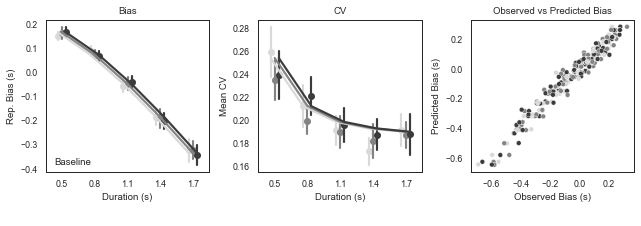

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.007,0.002,0.004,0.011,0.0,0.0,4618.0,3038.0,1.0
var_n[12],0.003,0.002,0.000,0.006,0.0,0.0,4540.0,3624.0,1.0
var_n[13],0.006,0.002,0.002,0.009,0.0,0.0,4421.0,3566.0,1.0
var_n[14],0.010,0.003,0.004,0.017,0.0,0.0,3801.0,3729.0,1.0


In [266]:
baseline_mdat['Exp'] = 'Baseline'
baseline_mdat['Gap'] = 0.5
plotModelPred(baseline_mdat, 'baseline')
az.summary(baseline_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [267]:
np.corrcoef(baseline_mdat['mPred'], baseline_mdat['repDur_mean'])

array([[1.        , 0.98826737],
       [0.98826737, 1.        ]])

In [268]:
#correlation of CV
np.corrcoef(baseline_mdat['repCV'], baseline_mdat['predCV'])

array([[1.       , 0.7551955],
       [0.7551955, 1.       ]])

## Memory Load on Encoding and Reproduction


In [269]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = False
if firstrun:
	constrain = [1,1,1,0] # scaling factor for k_s, l_s, gap, k_r
	#both_trace, both_model, both_para, both_mdat, both_new, both__group, both_preds = runModel(dat_both, constrain, modelpath + 'both')
	both_trace, both_para, both_new, both_group = runModel(dat_both, constrain, modelpath + 'both')
else:
	both_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_para.csv')

In [270]:
both_new['Exp'] = 'Both'
both_new.to_csv(cpath + '/data/'+ modelpath + 'Both_new_all.csv')
both_new

,NSub,xnew,WMSize,Gap,mPred,sdPred,CI_low,CI_high,pred_lower,pred_upper,Exp
0,1,0.40,1,0.5,0.538852,0.209602,0.135855,0.958625,0.135855,0.958625,Both
1,1,0.41,1,0.5,0.540217,0.210397,0.116880,0.953389,0.116880,0.953389,Both
2,1,0.42,1,0.5,0.554374,0.205905,0.152491,0.967531,0.152491,0.967531,Both
3,1,0.43,1,0.5,0.560228,0.209940,0.136199,0.970225,0.136199,0.970225,Both
4,1,0.44,1,0.5,0.564494,0.204674,0.156474,0.958116,0.156474,0.958116,Both
...,...,...,...,...,...,...,...,...,...,...,...
13531,16,1.76,5,2.5,1.301751,0.266729,0.784957,1.812508,0.784957,1.812508,Both
13532,16,1.77,5,2.5,1.311278,0.270788,0.784900,1.848413,0.784900,1.848413,Both
13533,16,1.78,5,2.5,1.316097,0.270140,0.793807,1.836154,0.793807,1.836154,Both
13534,16,1.79,5,2.5,1.329946,0.269575,0.789204,1.859976,0.789204,1.859976,Both


In [271]:
both_group['Exp'] = 'Both'
both_group.to_csv(cpath + '/data/'+ modelpath + 'Both_group.csv')

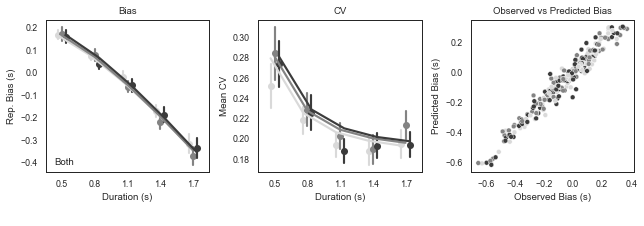

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.063,0.025,0.018,0.100,0.0,0.0,3108.0,2126.0,1.00
k_s[1],0.061,0.025,0.018,0.100,0.0,0.0,4058.0,2539.0,1.00
k_s[2],0.050,0.029,0.006,0.100,0.0,0.0,5288.0,3075.0,1.00
k_s[3],0.054,0.028,0.008,0.099,0.0,0.0,5362.0,2428.0,1.00
k_s[4],0.061,0.025,0.017,0.100,0.0,0.0,4937.0,2590.0,1.00
...,...,...,...,...,...,...,...,...,...
var_n[11],0.011,0.005,0.002,0.020,0.0,0.0,5302.0,3441.0,1.00
var_n[12],0.001,0.001,0.000,0.003,0.0,0.0,3237.0,3262.0,1.00
var_n[13],0.004,0.002,0.000,0.007,0.0,0.0,4123.0,3627.0,1.00
var_n[14],0.013,0.004,0.006,0.020,0.0,0.0,2624.0,3036.0,1.01


In [272]:
both_mdat['Exp'] = 'Both'
both_mdat['Gap'] = 0.5
plotModelPred(both_mdat, 'both')
az.summary(both_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [273]:
np.corrcoef(both_mdat['mPred'], both_mdat['repDur_mean'])

array([[1.        , 0.98640785],
       [0.98640785, 1.        ]])

In [274]:
#correlation of CV
np.corrcoef(both_mdat['repCV'], both_mdat['predCV'])

array([[1.        , 0.77261059],
       [0.77261059, 1.        ]])

Plot for four experiments together

AttributeError: 'Legend' object has no attribute 'set_loc'

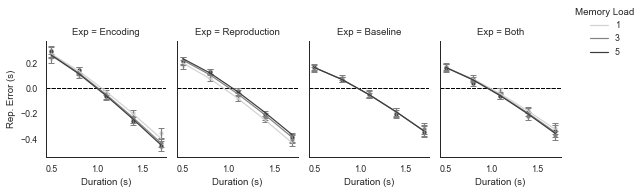

In [275]:
# combine encoding_mdat, reproduction_mdat, baseline_mdat, and both_mdat into mdat, but each data has additional column ExpName
exp_order = ['Encoding', 'Reproduction', 'Baseline', 'Both']
c_palette = ['lightgrey', '#838383',"#3b3b3b"] # consistent with R plot

mdat = pd.concat([encoding_mdat, reproduction_mdat, baseline_mdat, both_mdat], ignore_index=True)

# group and flatten the columns
mmdat = mdat.groupby(['curDur', 'WMSize', 'Exp'], observed =True).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
									'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

# Create the FacetGrid, faceting on the ExpName column
g1 = sns.FacetGrid(mmdat, col="Exp", hue="WMSize", height=2.5, aspect=0.8,col_order=exp_order, palette=c_palette)

# Map the scatter plot for reproduction error (repErr_mean)
g1.map(sns.scatterplot, 'curDur', 'repErr_mean')

# Add error bars to the scatter plots
def add_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=3, color='gray')

# Define a function to add the horizontal line at y=0
def add_hline(*args, **kwargs):
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Adds the horizontal line at y=0
# Add the horizontal line at y=0 to each subplot
g1.map(add_hline)

g1.map(add_error_bars, 'curDur', 'repErr_mean', 'repErr_sem')
# Map the line plot for predicted error (predErr_mean)
g1.map(sns.lineplot, 'curDur', 'predErr_mean')



# Customize the plot aesthetics
g1.set_axis_labels('Duration (s)', 'Rep. Error (s)')
# add legend on the top right corner
g1.add_legend(title='Memory Load')
# Adjust the legend position to the upper right corner of the entire plot
g1._legend.set_bbox_to_anchor((1, 0.9))  # Moves the legend to the upper right of the figure
g1._legend.set_loc('upper right')      # Aligns the legend to the upper right corner
# add label a to the top left corner of the first axis
g1.axes[0,0].text(0.01, 0.98, 'a', transform=g1.figure.transFigure, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
# save the figure to prediction_errors.png
plt.savefig(savefigpth + modelname+'_prediction_errors.png')
# Show the plot

plt.show()

In [ ]:

# Define a function to add the diagonal line
def add_diagonal(*args, **kwargs):
    ax = plt.gca()  # Get the current axis
    limits = [min(-0.6, -0.6), max(0.6, 0.6)]
    ax.plot(limits, limits, color='black', linestyle='--', linewidth=1)  # Draws the diagonal line

# now create the second pred. vs. obs. plot
# Create the FacetGrid, faceting on the ExpName column
g2 = sns.FacetGrid(mdat, col="Exp", hue="WMSize", height=2.5, aspect=1,col_order=exp_order, palette=c_palette)
# Map the scatter plot for reproduction error (repErr_mean)
g2.map(sns.scatterplot, 'repErr', 'predErr')
# Add the diagonal line to each subplot
g2.map(add_diagonal)

# set x and y labels
g2.set_axis_labels('Observed Error (s)', 'Predicted Error (s)')
#g2.add_legend()
#g2._legend.set_title('Memory Load')
# add label a to the top left corner of the first axis
g2.axes[0,0].text(0.0, 0.98, 'b', transform=g2.fig.transFigure, fontsize=16, fontweight='bold', va='top')
# save the figure to predict_vs_obs.png
plt.savefig(savefigpath + 'predict_vs_obs.png')


## Memory load with Gap on Encoding and Reproduction

In [ ]:
constrain = [1,1,1,1]

In [ ]:
both_gap_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_gap_trace.nc')

In [ ]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
firstrun = False
if firstrun:
	constrain = [1,1,1,1] # scaling factor for k_s, l_s, gap, k_r
	#both_gap_trace, both_gap_model, both_gap_para, both_gap_mdat, both_gap_new, both_gap_group, both_gap_preds = runModel(dat_gap, constrain, modelpath + 'both_gap')
	both_gap_trace, both_gap_para, both_gap_new, both_gap_group = runModel(dat_gap, constrain, modelpath + 'both_gap')
else:
	both_gap_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_gap_trace.nc')
	both_gap_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_mdat.csv')
	both_gap_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_para.csv')

In [ ]:
both_gap_new['Exp'] = 'Both_gap'
both_gap_new.to_csv(cpath + '/data/'+ modelpath + 'Both_gap_new_all.csv')

In [ ]:
both_gap_group['Exp'] = 'Both_gap'
both_gap_group.to_csv(cpath + '/data/'+ modelpath + 'Both_gap_group.csv')

In [ ]:
both_gap_trace.posterior.data_vars

In [ ]:
az.summary(both_gap_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])	

In [ ]:
both_gap_mdat['Exp'] = 'Both_gap'
plotModelPred(both_gap_mdat, 'both_gap')

In [ ]:
np.corrcoef(both_gap_mdat['mPred'], both_gap_mdat['repDur_mean'])

In [ ]:
#correlation of CV
np.corrcoef(both_gap_mdat['repCV'], both_gap_mdat['predCV'])

## Estimated Parameters

Note: Visual differences, $l_s$ was higher for Exp. 6a than others, while $k_r$ was close to zero for Exp. 6a. 

In [ ]:
def compute_subject_level_k_statistics(trace, k_param):
    """
    Computes the mean and standard deviation of parameter k_param for each subject
    from a PyMC InferenceData object (trace).

    Parameters:
    ----------
    trace : arviz.InferenceData
        The trace from the PyMC model containing posterior samples.
    k_param : str
        The name of the parameter (e.g., 'k_s', 'l_s', 't_s', 'k_r').

    Returns:
    -------
    k_mean : np.ndarray
        The posterior mean of the parameter for each subject.
    k_sd : np.ndarray
        The posterior standard deviation of the parameter for each subject.
    """

    # Check if parameter exists in the trace
    if k_param not in trace.posterior:
        raise ValueError(f"Parameter '{k_param}' not found in trace.posterior.")

    # Extract posterior samples for k_param: shape (nchains, ndraws, nsub)
    k_samples = trace.posterior[k_param].values

    # Flatten chains and draws -> shape (nchains * ndraws, nsub)
    k_samples_flat = k_samples.reshape(-1, k_samples.shape[-1])

    # Compute mean and standard deviation across posterior samples
    k_mean = np.mean(k_samples_flat, axis=0)
    k_sd = np.std(k_samples_flat, axis=0)

    return k_mean, k_sd

In [ ]:
modelpath

In [ ]:
#'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'

ks_encoding, ks_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_s')
ls_encoding, ls_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'l_s')
kr_encoding, kr_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_r')
ts_encoding, ts_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 't_s')
var_s_encoding, var_s_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_s')
mu_p_encoding, mu_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'mu_p')
var_p_encoding, var_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_p')
var_n_encoding, var_n_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_n')


ks_reproduction, ks_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_s')
ls_reproduction, ls_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'l_s')
kr_reproduction, kr_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_r')
ts_reproduction, ts_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 't_s')
var_s_reproduction, var_s_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_s')
mu_p_reproduction, mu_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'mu_p')
var_p_reproduction, var_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_p')
var_n_reproduction, var_n_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_n')

ks_both, ks_both_sd = compute_subject_level_k_statistics(both_trace, 'k_s')
ls_both, ls_both_sd = compute_subject_level_k_statistics(both_trace, 'l_s')
kr_both, kr_both_sd = compute_subject_level_k_statistics(both_trace, 'k_r')
ts_both, ts_both_sd = compute_subject_level_k_statistics(both_trace, 't_s')
var_s_both, var_s_both_sd = compute_subject_level_k_statistics(both_trace, 'var_s')
mu_p_both, mu_p_both_sd = compute_subject_level_k_statistics(both_trace, 'mu_p')
var_p_both, var_p_both_sd = compute_subject_level_k_statistics(both_trace, 'var_p')
var_n_both, var_n_both_sd = compute_subject_level_k_statistics(both_trace, 'var_n')

ks_both_gap, ks_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_s')
ls_both_gap, ls_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'l_s')
kr_both_gap, kr_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_r')
ts_both_gap, ts_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 't_s')
var_s_both_gap, var_s_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_s')
mu_p_both_gap, mu_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'mu_p')
var_p_both_gap, var_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_p')
var_n_both_gap, var_n_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_n')


ks_baseline, ks_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_s')
ls_baseline, ls_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'l_s')
kr_baseline, kr_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_r')
ts_baseline, ts_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 't_s')
var_s_baseline, var_s_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_s')
mu_p_baseline, mu_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'mu_p')
var_p_baseline, var_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_p')
var_n_baseline, var_n_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_n')


In [ ]:
# combine means together
para = [ks_encoding, ks_reproduction, ks_baseline, ks_both, ks_both_gap,
		ls_encoding, ls_reproduction, ls_baseline, ls_both, ls_both_gap,
		kr_encoding, kr_reproduction, kr_baseline, kr_both, kr_both_gap, 
        ts_encoding, ts_reproduction, ts_baseline, ts_both, ts_both_gap, 
		var_s_encoding, var_s_reproduction, var_s_baseline, var_s_both, var_s_both_gap, 
		mu_p_encoding, mu_p_reproduction, mu_p_baseline, mu_p_both, mu_p_both_gap, 
        var_p_encoding, var_p_reproduction, var_p_baseline, var_p_both, var_p_both_gap, 
		var_n_encoding, var_n_reproduction,  var_n_baseline, var_n_both, var_n_both_gap]
# reshape the array, each array has (16,)
para_r = np.stack(para, axis=0).reshape(-1, 80).T
# create a dataframe
df_para = pd.DataFrame(para_r, columns = ['ks','ls','kr', 'ts', 'var_s', 'mu_log', 'sigma_log', 'var_n'])

df_para['mu_p'] = np.exp(df_para['mu_log'] + 0.5 * df_para['sigma_log']**2)
df_para['var_p'] = np.sqrt((np.exp(df_para['sigma_log']**2) - 1) * np.exp(2*df_para['mu_log'] + df_para['sigma_log']**2))
df_para['Exp'] = ['Encoding']*16 + ['Reproduction']*16 + ['Baseline']*16 + ['Both']*16 + ['Both_gap']*16
# delete mean prior and variance of prior in log scale
#df_para = df_para.drop(columns=['mu_log', 'sigma_log'])
n = len(df_para)
df_para["NSub"] = np.tile(np.arange(1, 17), int(np.ceil(n / 16)))[:n]
df_para.head()



In [ ]:
#plot mean and SEs of 'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n' as a function of Experiment
fig, ax = plt.subplots(2, 4, figsize=(9, 5))
fig.suptitle("", fontsize=14)

params = [
    ('ks', '$k_s$'),
    ('ls', '$l_s$'),
    ('kr', '$k_r$'),
    ('ts', '$t_s$'),
    ('var_s', '$var_s$'),
    ('mu_p', '$mu_p$'),
    ('var_p', '$var_p$'),
    ('var_n', '$var_n$')
]

# 循环绘制子图
for i, (param, title) in enumerate(params):
    row, col = divmod(i, 4)
    sns.barplot(
        data=df_para,
        x='Exp',
        y=param,
        errorbar='se',
        ax=ax[row, col],
        color='gray'
    )
    ax[row, col].set_title(title)
    ax[row, col].set_ylabel('Mean')
    ax[row, col].set_xlabel('')
    ax[row, col].tick_params(axis='x', rotation=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(savefigpath + 'Para_' + modelname + '.png', dpi=1200)
plt.show()


##  weight of prior

In [276]:

wm_values = [1, 3, 5]
df_para_expanded = ( df_para.loc[df_para.index.repeat(len(wm_values))]      # 每行重复3次
      .assign(WMSize = np.tile(wm_values, len(df_para)))  # 为每个重复行分配1,3,5
      .reset_index(drop=True)
)


# 定义两个 gap 值
gaps = [0.5, 2.5]

# 分离 Both_gap 和 其他实验
df_bg = df_para_expanded[df_para_expanded["Exp"] == "Both_gap"].copy()
df_other = df_para_expanded[df_para_expanded["Exp"] != "Both_gap"].copy()

# ---- 为 Both_gap 扩展 Gap 两个值 ----
df_bg_expanded = (
    df_bg.loc[df_bg.index.repeat(2)]                          # 每行重复 2 次
         .assign(Gap = np.tile(gaps, len(df_bg)))            # 交替赋值 0.5, 2.5
)

# ---- 其他实验 Gap=0.5 （不扩展）----
df_other["Gap"] = 0.5

# ---- 合并 ----
paraList = (
    pd.concat([df_other, df_bg_expanded], ignore_index=True)
      .sort_values(["Exp"])
      .reset_index(drop=True)
)

paraList

,ks,ls,kr,ts,var_s,mu_log,sigma_log,var_n,mu_p,var_p,Exp,NSub,WMSize,Gap
0,0.0,0.0,0.000000,0.0,0.063004,-0.120682,0.122661,0.004884,0.893008,0.109951,Baseline,16,5,0.5
1,0.0,0.0,0.000000,0.0,0.029281,0.253300,0.069139,0.009559,1.291352,0.089389,Baseline,9,3,0.5
2,0.0,0.0,0.000000,0.0,0.029281,0.253300,0.069139,0.009559,1.291352,0.089389,Baseline,9,5,0.5
3,0.0,0.0,0.000000,0.0,0.097624,-0.053483,0.091808,0.003775,0.951926,0.087578,Baseline,10,1,0.5
4,0.0,0.0,0.000000,0.0,0.097624,-0.053483,0.091808,0.003775,0.951926,0.087578,Baseline,10,3,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.0,0.0,0.043476,0.0,0.037337,-0.211623,0.110380,0.005484,0.814215,0.090148,Reproduction,7,5,0.5
284,0.0,0.0,0.013536,0.0,0.093524,0.104915,0.037453,0.030202,1.111395,0.041640,Reproduction,8,1,0.5
285,0.0,0.0,0.013536,0.0,0.093524,0.104915,0.037453,0.030202,1.111395,0.041640,Reproduction,8,3,0.5
286,0.0,0.0,0.013794,0.0,0.081909,-0.071409,0.048634,0.021498,0.932183,0.045363,Reproduction,1,1,0.5


In [277]:
#var_wm = var_s[subid] * (1 + l_s[subid] * wm_idx + t_s[subid] * gap_idx)
 #w_p = var_wm / (var_p[subid] + var_wm)

paraList["var_wm"] = paraList["var_s"] *(1+paraList["ls"]*paraList["WMSize"] +paraList["ts"]*paraList["Gap"])
paraList["w_p"] = paraList["var_wm"] /(paraList["var_p"] + paraList["var_wm"])
paraList.to_csv(OUTPUT_PATH + '/'+ modelname + '_ParaList.csv')
paraList

,ks,ls,kr,ts,var_s,mu_log,sigma_log,var_n,mu_p,var_p,Exp,NSub,WMSize,Gap,var_wm,w_p
0,0.0,0.0,0.000000,0.0,0.063004,-0.120682,0.122661,0.004884,0.893008,0.109951,Baseline,16,5,0.5,0.063004,0.364280
1,0.0,0.0,0.000000,0.0,0.029281,0.253300,0.069139,0.009559,1.291352,0.089389,Baseline,9,3,0.5,0.029281,0.246742
2,0.0,0.0,0.000000,0.0,0.029281,0.253300,0.069139,0.009559,1.291352,0.089389,Baseline,9,5,0.5,0.029281,0.246742
3,0.0,0.0,0.000000,0.0,0.097624,-0.053483,0.091808,0.003775,0.951926,0.087578,Baseline,10,1,0.5,0.097624,0.527121
4,0.0,0.0,0.000000,0.0,0.097624,-0.053483,0.091808,0.003775,0.951926,0.087578,Baseline,10,3,0.5,0.097624,0.527121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.0,0.0,0.043476,0.0,0.037337,-0.211623,0.110380,0.005484,0.814215,0.090148,Reproduction,7,5,0.5,0.037337,0.292873
284,0.0,0.0,0.013536,0.0,0.093524,0.104915,0.037453,0.030202,1.111395,0.041640,Reproduction,8,1,0.5,0.093524,0.691929
285,0.0,0.0,0.013536,0.0,0.093524,0.104915,0.037453,0.030202,1.111395,0.041640,Reproduction,8,3,0.5,0.093524,0.691929
286,0.0,0.0,0.013794,0.0,0.081909,-0.071409,0.048634,0.021498,0.932183,0.045363,Reproduction,1,1,0.5,0.081909,0.643577


## Predicted RP 

In [278]:
newdat_all = pd.concat([encoding_new, reproduction_new, baseline_new, both_new, both_gap_new])
newdat_all.to_csv(OUTPUT_PATH + '/'+ modelname + '_newdat_all.csv')

In [279]:
both_gap_new

,NSub,xnew,WMSize,Gap,mPred,sdPred,CI_low,CI_high,pred_lower,pred_upper,Exp
0,1,0.40,1,0.5,0.466626,0.107345,0.253160,0.673738,0.253160,0.673738,Both_gap
1,1,0.41,1,0.5,0.475642,0.106117,0.266157,0.680258,0.266157,0.680258,Both_gap
2,1,0.42,1,0.5,0.485836,0.108290,0.271943,0.704096,0.271943,0.704096,Both_gap
3,1,0.43,1,0.5,0.494409,0.108362,0.284596,0.711109,0.284596,0.711109,Both_gap
4,1,0.44,1,0.5,0.503918,0.106370,0.293358,0.708449,0.293358,0.708449,Both_gap
...,...,...,...,...,...,...,...,...,...,...,...
13531,16,1.76,5,2.5,1.571448,0.303266,0.985603,2.169696,0.985603,2.169696,Both_gap
13532,16,1.77,5,2.5,1.580336,0.304484,0.980247,2.176951,0.980247,2.176951,Both_gap
13533,16,1.78,5,2.5,1.583348,0.310796,0.986967,2.205032,0.986967,2.205032,Both_gap
13534,16,1.79,5,2.5,1.587881,0.307162,0.997630,2.191285,0.997630,2.191285,Both_gap


In [280]:
mdat_all = pd.concat([encoding_mdat, reproduction_mdat, baseline_mdat, both_mdat,both_gap_mdat])
mdat_all['WMSize'] = (
    mdat_all['WMSize']
    .replace({1: "Low", 3: "Med", 5: "High"})
    .astype(str)
)
mdat_all
mdat_all = mdat_all.drop(columns=['gap'])

In [281]:
mdat_all
mdat_all.to_csv(OUTPUT_PATH + '/'+ modelname + '_mdat_all.csv')

In [282]:
print(df_para["Exp"].unique())

['Encoding' 'Reproduction' 'Baseline' 'Both' 'Both_gap']


In [283]:
# =========================================================
# 1. 新输入：xnew, Gapnew, WMSize_new  （846 rows）
# =========================================================
xnew = np.tile(np.linspace(0.4, 1.8, 141), 6)
Gapnew = np.repeat([0.5], repeats=141*6)
WMSizenew = np.concatenate([
    np.repeat(1, 141),
    np.repeat(3, 141),
    np.repeat(5, 141),
    np.repeat(1, 141),
    np.repeat(3, 141),
    np.repeat(5, 141)
])

# =========================================================
# 2. 预测函数
# =========================================================
def predict_single_subject(params, xnew, Gapnew, WMSize_new, exp):
    """
    params: dict-like, 单个被试的一行参数
    返回一个 846 维向量（该被试对所有新输入的预测）
    """

    D_s = np.log(xnew) - params["ks"] * WMSize_new
    if(exp == "Both_gap"):
        var_wm = params["var_s"] * (1 + params["ls"] * WMSize_new + params["ts"] * Gapnew)
    else:
        var_wm = params["var_s"] * (1 + params["ls"] * WMSize_new)
    w_p = var_wm / (params["sigma_log"] + var_wm)
    u_x = (1 - w_p) * D_s + w_p * params["mu_log"]
    var_x = var_wm * params["sigma_log"] / (var_wm + params["sigma_log"])
    u_x1 = u_x + params["kr"] * WMSize_new
    u_r = u_x1 + var_x / 2
    return u_r


# =========================================================
# 3. 主循环：Experiment → Subject → 预测
# =========================================================

experiments = ["Encoding", "Reproduction", "Baseline", "Both", "Both_gap"]

# 保存所有预测的大矩阵
# 每个 subject 产生 846 个预测
predictions = []        # 将来 concat
meta_info = []          # 保存 subject info（exp, id）

for exp in experiments:
    df_exp = df_para[df_para["Exp"] == exp]
    if(exp == "Both_gap"):
        Gapnew = np.repeat([0.5, 2.5], repeats=141*3)
    else:
        Gapnew = np.repeat([0.5], repeats=141*6)
        

    for sub in df_exp["NSub"].unique():

        df_sub = df_exp[df_exp["NSub"] == sub]

        # ---- 每位被试应该只有一行 ----
        params = df_sub.iloc[0].to_dict()

        # ---- 调用预测函数（846 条输出）----
        pred = predict_single_subject(params, xnew, Gapnew, WMSizenew, exp)
        #  合并成一个数组（846 行 × 4 列）
        rlt = np.column_stack([xnew, Gapnew, WMSizenew, pred])
        # 转成 DataFrame
        df_rlt = pd.DataFrame(rlt, columns=["curDur", "Gap", "WMSize", "mu_r"])

        df_rlt["Exp"] = exp
        df_rlt["NSub"] = sub

        # ---- 保存结果 ----
        predictions.append(df_rlt)

        
# =========================================================
# 4. 转成 DataFrame：所有 subject 的预测拼成一个大表
# =========================================================
pred_df = pd.concat(predictions, ignore_index=True)
pred_df["mu_r"] = np.exp(pred_df["mu_r"])
pred_df.to_csv(OUTPUT_PATH + '/'+ modelname + '_PredRPList.csv')
print(pred_df.head())
print(pred_df.shape)


   curDur  Gap  WMSize      mu_r       Exp  NSub
0    0.40  0.5     1.0  0.701345  Encoding     1
1    0.41  0.5     1.0  0.708187  Encoding     1
2    0.42  0.5     1.0  0.714928  Encoding     1
3    0.43  0.5     1.0  0.721573  Encoding     1
4    0.44  0.5     1.0  0.728124  Encoding     1
(67680, 6)


## one-way anova test  on estimated parameters

In [284]:
# one-way anova test for k_s, factor is Experiment, with data df_para
import pingouin as pg
aov = pg.anova(data=df_para, dv='ks', between='Exp', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Exp,0.071884,4,0.017971,94.853857,1.477931e-28,0.834953
1,Within,0.014210,75,0.000189,NaN,NaN,NaN


In [285]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ks', between='Exp', padjust='holm')
posthoc

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Exp,Baseline,Both,False,True,-20.217184,30.0,two-sided,4.988180e-19,4.489362e-18,holm,4.61e+15,-6.967656
1,Exp,Baseline,Both_gap,False,True,-13.426440,30.0,two-sided,3.207285e-14,2.245100e-13,holm,1.165e+11,-4.627292
2,Exp,Baseline,Encoding,False,True,-9.575395,30.0,two-sided,1.244462e-10,6.222309e-10,holm,4.735e+07,-3.300067
3,Exp,Baseline,Reproduction,False,True,NaN,30.0,two-sided,NaN,NaN,holm,nan,NaN
4,Exp,Both,Both_gap,False,True,-1.302948,30.0,two-sided,2.025052e-01,2.025052e-01,holm,0.64,-0.449048
5,Exp,Both,Encoding,False,True,2.829500,30.0,two-sided,8.235599e-03,1.647120e-02,holm,5.867,0.975160
6,Exp,Both,Reproduction,False,True,20.217184,30.0,two-sided,4.988180e-19,4.489362e-18,holm,4.61e+15,6.967656
7,Exp,Both_gap,Encoding,False,True,3.388116,30.0,two-sided,1.984653e-03,5.953959e-03,holm,17.827,1.167681
8,Exp,Both_gap,Reproduction,False,True,13.426440,30.0,two-sided,3.207285e-14,2.245100e-13,holm,1.165e+11,4.627292
9,Exp,Encoding,Reproduction,False,True,9.575395,30.0,two-sided,1.244462e-10,6.222309e-10,holm,4.735e+07,3.300067


In [286]:
aov = pg.anova(data=df_para, dv='ls', between='Exp', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Exp,0.060239,4,0.015060,197.416945,5.371251e-39,0.913261
1,Within,0.005721,75,0.000076,NaN,NaN,NaN


In [287]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ls', between='Exp', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd
/Users/fi

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Exp,Baseline,Both,False,True,-30.138,30.0,two-sided,0.000,0.000,holm,2.72e+20,-10.387
1,Exp,Baseline,Both_gap,False,True,-13.714,30.0,two-sided,0.000,0.000,holm,1.965e+11,-4.726
2,Exp,Baseline,Encoding,False,True,-41.956,30.0,two-sided,0.000,0.000,holm,3.138e+24,-14.460
3,Exp,Baseline,Reproduction,False,True,NaN,30.0,two-sided,NaN,NaN,holm,nan,NaN
4,Exp,Both,Both_gap,False,True,-1.982,30.0,two-sided,0.057,0.113,holm,1.445,-0.683
5,Exp,Both,Encoding,False,True,-2.497,30.0,two-sided,0.018,0.055,holm,3.233,-0.860
6,Exp,Both,Reproduction,False,True,30.138,30.0,two-sided,0.000,0.000,holm,2.72e+20,10.387
7,Exp,Both_gap,Encoding,False,True,0.858,30.0,two-sided,0.398,0.398,holm,0.446,0.296
8,Exp,Both_gap,Reproduction,False,True,13.714,30.0,two-sided,0.000,0.000,holm,1.965e+11,4.726
9,Exp,Encoding,Reproduction,False,True,41.956,30.0,two-sided,0.000,0.000,holm,3.138e+24,14.460


In [288]:
aov = pg.anova(data=df_para, dv='kr', between='Exp', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Exp,0.014417,4,0.003604,24.763773,4.346642e-13,0.569102
1,Within,0.010916,75,0.000146,NaN,NaN,NaN


In [289]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='kr', between='Exp', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Exp,Baseline,Both,False,True,-8.757,30.0,two-sided,0.000,0.000,holm,7.344e+06,-3.018
1,Exp,Baseline,Both_gap,False,True,-5.153,30.0,two-sided,0.000,0.000,holm,1080.246,-1.776
2,Exp,Baseline,Encoding,False,True,NaN,30.0,two-sided,NaN,NaN,holm,nan,NaN
3,Exp,Baseline,Reproduction,False,True,-7.271,30.0,two-sided,0.000,0.000,holm,2.102e+05,-2.506
4,Exp,Both,Both_gap,False,True,1.152,30.0,two-sided,0.258,0.517,holm,0.557,0.397
5,Exp,Both,Encoding,False,True,8.757,30.0,two-sided,0.000,0.000,holm,7.344e+06,3.018
6,Exp,Both,Reproduction,False,True,-0.675,30.0,two-sided,0.505,0.517,holm,0.401,-0.233
7,Exp,Both_gap,Encoding,False,True,5.153,30.0,two-sided,0.000,0.000,holm,1080.246,1.776
8,Exp,Both_gap,Reproduction,False,True,-1.607,30.0,two-sided,0.119,0.356,holm,0.888,-0.554
9,Exp,Encoding,Reproduction,False,True,-7.271,30.0,two-sided,0.000,0.000,holm,2.102e+05,-2.506


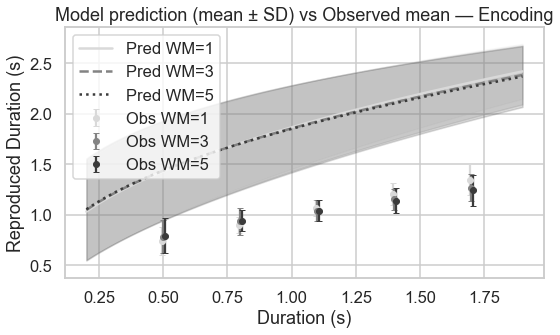

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_subject_predictions(df_para, exp_name='Encoding', wm_levels=None, dur_grid=None, gap_value=0.0):
    """
    For each subject in df_para (filtered by exp_name), compute predicted mPred over dur_grid and wm_levels.
    Returns:
      pred_per_subject: DataFrame with columns ['Subject','curDur','WMSize','mPred']
      group_pred: DataFrame grouped by ['curDur','WMSize'] with mPred_mean and mPred_std
    Assumes df_para rows correspond to subjects and contain columns:
      ks, ls, kr, ts, var_s, var_n, mu_p, var_p, Exp
    """
    # defaults
    if dur_grid is None:
        dur_grid = np.linspace(0.2, 1.9, 200)
    if wm_levels is None:
        # try infer from encoding_mdat later; for now use common default
        wm_levels = [1, 3, 5]

    dfp = df_para[df_para['Exp'] == exp_name].reset_index(drop=True)
    rows = []
    for subj_idx, row in dfp.iterrows():
        subj_id = subj_idx + 1  # assume subject numbering aligns like this; adjust if needed
        ks = row['ks']; ls = row['ls']; kr = row['kr']; ts = row['ts']
        var_s = row['var_s']; var_n = row['var_n']; mu_p = row['mu_p']; var_p = row['var_p']

        for wm in wm_levels:
            wm_idx = np.log(wm)
            for dur in dur_grid:
                lnDur = np.log(dur)
                # gap handling: if you have real gap values you can pass them; otherwise use gap_value
                gap_idx = np.log(gap_value) if (gap_value is not None and gap_value > 0) else 0.0

                # === model equations (unchanged signs) ===
                D_s = lnDur - ks * wm_idx
                var_wm = var_s * (1 + ls * wm_idx + ts * gap_idx)
                # avoid numerical issues
                var_wm = np.maximum(var_wm, 1e-10)
                denom = var_p + var_wm
                denom = np.maximum(denom, 1e-10)

                w_p = var_wm / denom
                u_x = (1 - w_p) * D_s + w_p * mu_p
                var_x = (var_wm * var_p) / denom
                u_x1 = u_x + kr * wm_idx

                mPred = np.exp(u_x1 + var_x / 2.0)  # predicted mean on linear scale

                rows.append({
                    'Subject': subj_id,
                    'curDur': dur,
                    'WMSize': wm,
                    'mPred': mPred
                })

    pred_per_subject = pd.DataFrame(rows)

    # group summary (mean ± std across subjects)
    group_pred = pred_per_subject.groupby(['curDur', 'WMSize']).agg(
        mPred_mean=('mPred', 'mean'),
        mPred_std=('mPred', 'std')
    ).reset_index()

    return pred_per_subject, group_pred


def plot_pred_vs_obs_by_wm(group_pred, obs_df, exp_name='Encoding', linestyles=None, colors=None,
                           savepath=None, show_shade=True, use_obs_sd=True):
    """
    Plot predicted group mean ± SD for each WM (different linestyles) and observed group means.
    obs_df should contain columns ['curDur','WMSize','repDur_mean'] and optionally 'repDur_std'.
    """
    sns.set_theme(style='whitegrid', context='talk')

    if linestyles is None:
        linestyles = ['-', '--', ':', '-.']
    if colors is None:
        colors = ['#d9d9d9', '#838383', '#3b3b3b', '#000000']

    wm_levels = sorted(group_pred['WMSize'].unique())
    color_map = {wm: colors[i % len(colors)] for i, wm in enumerate(wm_levels)}
    ls_map = {wm: linestyles[i % len(linestyles)] for i, wm in enumerate(wm_levels)}

    fig, ax = plt.subplots(figsize=(8, 5))

    # plot predicted mean + shaded std
    for wm in wm_levels:
        sub = group_pred[group_pred['WMSize'] == wm].sort_values('curDur')
        x = sub['curDur'].values
        y = sub['mPred_mean'].values
        ystd = sub['mPred_std'].values

        ax.plot(x, y, color=color_map[wm], linestyle=ls_map[wm], linewidth=2.5, label=f'Pred WM={wm}')
        if show_shade:
            ax.fill_between(x, y - ystd, y + ystd, color=color_map[wm], alpha=0.18)

    # prepare observed group means (mean across subjects) if obs_df contains per-subject rows
    # If obs_df already is grouped across subjects (mdat), use it directly.
    obs = obs_df.copy()
    # Ensure columns exist
    if 'repDur_mean' not in obs.columns:
        raise ValueError("obs_df must contain column 'repDur_mean' (observed mean per curDur x WM).")
    # If repDur_std missing, set zeros
    if 'repDur_std' not in obs.columns:
        obs['repDur_std'] = 0.0

    # plot observed means with errorbars (use SD or SE depending on use_obs_sd)
    for wm in sorted(obs['WMSize'].unique()):
        dsub = obs[obs['WMSize'] == wm].sort_values('curDur')
        x = dsub['curDur'].values
        y = dsub['repDur_mean'].values
        err = dsub['repDur_std'].values if use_obs_sd else dsub['repDur_std'].values / np.sqrt(max(1, dsub.shape[0]))
        # small jitter on x to avoid overlapping markers
        jitter = (np.array([ -0.006, 0.0, 0.006, 0.012 ])[( (wm_levels.index(wm)) % 4 )]) 
        ax.errorbar(x + jitter, y, yerr=err, fmt='o', color=color_map.get(wm, 'k'),
                    markersize=6, capsize=3, label=f'Obs WM={wm}', linestyle='')

    # auto y-limits: take min/max across predicted mean±std and observed points, add margin
    all_mins = []
    all_maxs = []
    # predictions
    all_mins.append((group_pred['mPred_mean'] - group_pred['mPred_std']).min())
    all_maxs.append((group_pred['mPred_mean'] + group_pred['mPred_std']).max())
    # observed
    all_mins.append((obs['repDur_mean'] - obs['repDur_std']).min())
    all_maxs.append((obs['repDur_mean'] + obs['repDur_std']).max())

    ymin = np.nanmin(all_mins)
    ymax = np.nanmax(all_maxs)
    # add small margins
    yrange = ymax - ymin if (ymax - ymin) > 0 else ymax * 0.1 + 0.1
    ax.set_ylim(ymin - 0.08 * yrange, ymax + 0.08 * yrange)

    ax.set_xlabel('Duration (s)')
    ax.set_ylabel('Reproduced Duration (s)')
    ax.set_title(f'Model prediction (mean ± SD) vs Observed mean — {exp_name}')

    # build legend without duplicates and in nice order: Pred lines first, then Obs
    handles, labels = ax.get_legend_handles_labels()
    # unique while preserving order
    unique = dict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), loc='upper left', frameon=True)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    plt.show()


# -------------------------
# Example usage:
# -------------------------
# df_para: DataFrame of parameters (per subject rows) with Exp column
# encoding_mdat: observed summary DataFrame with columns: NSub, curDur, WMSize, repDur_mean, repDur_std

exp_name = 'Encoding'

# 1) optionally infer WM levels from observed data
wm_levels_obs = sorted(encoding_mdat['WMSize'].astype(int).unique())

# 2) compute per-subject predictions and group summary
dur_grid = np.linspace(0.2, 1.9, 200)
pred_per_subj, group_pred = compute_subject_predictions(df_para, exp_name=exp_name,
                                                        wm_levels=wm_levels_obs, dur_grid=dur_grid,
                                                        gap_value=0.0)

# 3) prepare observed group-level mdat (mean ± std across subjects) for plotting
# If encoding_mdat already has per-subject repDur_mean and repDur_std, we first group across subjects:
obs_grouped = encoding_mdat.groupby(['curDur', 'WMSize']).agg(
    repDur_mean=('repDur_mean', 'mean'),
    repDur_std=('repDur_mean', 'std')  # sd across subjects' means; replace if you have per-subject SDs
).reset_index()

# 4) plot (linestyles differ per WM, auto y scaling, title with exp_name)
plot_pred_vs_obs_by_wm(group_pred, obs_grouped, exp_name=exp_name, savepath=None)


In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plotAllExperimentsPred(all_mdat, savefigpath='./', figname='allExp_model_pred.png'):
    """
    Plot observed vs predicted data (Bias, CV, Scatter) for all experiments in one figure.
    all_mdat: dataframe containing data from multiple experiments,
              must include columns ['Experiment','curDur','WMSize','repErr','predErr','repCV','predCV'].
    """
    # Make sure categorical
    all_mdat['WMSize'] = all_mdat['WMSize'].astype('category')
    experiments = all_mdat['Experiment'].unique()

    # seaborn style
    sns.set_theme(style="white", context="paper")
    customized_palette = sns.color_palette("gray", n_colors=len(all_mdat['WMSize'].unique()))

    # figure setup: one row per experiment, 3 cols (Bias, CV, Scatter)
    nExp = len(experiments)
    fig, axes = plt.subplots(nExp, 3, figsize=(9, 3 * nExp), squeeze=False)

    for i, exp in enumerate(experiments):
        mdat = all_mdat[all_mdat['Experiment'] == exp].copy()

        # --- Bias ---
        sns.pointplot(
            data=mdat, x='curDur', y='repErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 0],
            linestyles='', errorbar='se', dodge=0.2, legend=False
        )
        sns.pointplot(
            data=mdat, x='curDur', y='predErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 0],
            markers='', linestyles='-', errorbar=None, legend=False
        )
        axes[i, 0].set_title(f'{exp} — Bias')
        axes[i, 0].set_xlabel('Duration (s)')
        axes[i, 0].set_ylabel('Rep. Bias (s)')
        if i == 0:
            axes[i, 0].legend(title='WMSize')
        else:
            axes[i, 0].get_legend().remove()

        # --- CV ---
        sns.pointplot(
            data=mdat, x='curDur', y='repCV', hue='WMSize',
            palette=customized_palette, ax=axes[i, 1],
            linestyles='', errorbar='se', dodge=0.2, legend=False
        )
        sns.pointplot(
            data=mdat, x='curDur', y='predCV', hue='WMSize',
            palette=customized_palette, ax=axes[i, 1],
            markers='', linestyles='-', errorbar=None, legend=False
        )
        axes[i, 1].set_title(f'{exp} — CV')
        axes[i, 1].set_xlabel('Duration (s)')
        axes[i, 1].set_ylabel('Mean CV')

        # --- Scatter ---
        sns.scatterplot(
            data=mdat, x='repErr', y='predErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 2], legend=False
        )
        axes[i, 2].set_title(f'{exp} — Observed vs Predicted')
        axes[i, 2].set_xlabel('Observed Bias (s)')
        axes[i, 2].set_ylabel('Predicted Bias (s)')

        # Add experiment label to left bottom corner of the Bias panel
        axes[i, 0].text(0.05, 0.05, exp, transform=axes[i, 0].transAxes,
                        fontsize=9, color='black')

    plt.tight_layout()
    plt.savefig(savefigpath + figname, dpi=600)
    plt.show()


In [292]:
# 定义实验名称和对应变量名
experiments = {
    'Baseline': baseline_mdat,
    'Encoding': encoding_mdat,
    'Reproduction': reproduction_mdat,
    'Both': both_mdat,
    'Both_gap': both_gap_mdat
}

# 在每个 DataFrame 中添加 Experiment 列
for exp_name, df in experiments.items():
    df['Experiment'] = exp_name

# 拼接所有 DataFrame
all_mdat = pd.concat(experiments.values(), ignore_index=True)

# 检查结果
print(all_mdat.head())
print(all_mdat['Experiment'].value_counts())

   Unnamed: 0  NSub  curDur WMSize  repDur_mean  repDur_std     mPred  \
0           0     1     0.5      1     0.723200    0.166440  0.781059   
1           1     1     0.5      3     0.825337    0.203701  0.781585   
2           2     1     0.5      5     0.779297    0.206872  0.782085   
3           3     1     0.8      1     0.908631    0.132347  0.883882   
4           4     1     0.8      3     0.899939    0.243163  0.883940   

     sdPred    repErr   predErr     repCV    predCV       Exp  Gap Experiment  \
0  0.193308  0.223200  0.281059  0.230144  0.247495  Baseline  0.5   Baseline   
1  0.192730  0.325337  0.281585  0.246809  0.246588  Baseline  0.5   Baseline   
2  0.192819  0.279297  0.282085  0.265460  0.246545  Baseline  0.5   Baseline   
3  0.188973  0.108631  0.083882  0.145655  0.213799  Baseline  0.5   Baseline   
4  0.188147  0.099939  0.083940  0.270199  0.212851  Baseline  0.5   Baseline   

   gap  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  
Experiment
Both_gap 

In [294]:
#plotAllExperimentsPred(all_mdat)